In [118]:
dir()
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

In [119]:

#### 
import math
import sounddevice as sd
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import cmath 

In [120]:
#fs, data = wavfile.read('Cluster.wav')
fs, data = wavfile.read('Medicine.wav')
#data =data[141312:,0]
#data =data[:,0]

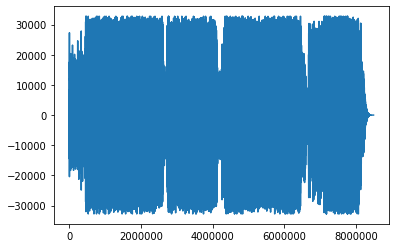

In [121]:
plt.plot(data)

In [17]:
sd.play(data,fs)

In [18]:
sd.stop()

In [122]:
def padding(data,window_len,hop_size,Ahop_times):
    #Ahop_times = int(np.ceil((len(data) - window_len)/hop_size))
    required_len = int(hop_size * (Ahop_times)+window_len)
    pad_len = required_len - len(data)
    #return [required_len,pad_len,np.append(data,np.zeros(pad_len))]
    return [pad_len,np.append(data,np.zeros(pad_len))]
    

In [123]:
def init_analysis_hop(data, window_len,overlap_factor):
    length_of_original = len(data)
    overlap_length= overlap_factor * window_len
    Analysis_H = (1-overlap_factor) * window_len
    #Ahop_times = round(length_of_original/ Analysis_H) -1
    Ahop_times = int(np.ceil((length_of_original - window_len)/Analysis_H))
    newData = padding(data, window_len,Analysis_H,Ahop_times)
    gama = Analysis_H * np.arange(0,Ahop_times+1)
    return [Ahop_times, gama, newData[0],newData[1]]
    
    

In [124]:
def analysis_slice(data, Ahop_times, gama,window_len):
    window = np.hamming(window_len)
    transformed_xw=[]
    for start_point in gama:
        start_point =int(start_point)
        xw =np.multiply(data[start_point:start_point+window_len],window)
        transformed_xw = transformed_xw + [np.fft.fft(xw)]
    print(len(transformed_xw))
    return transformed_xw

In [159]:
def init_synthesis_hop(stretch_factor,window_len,gama,transformed_xw):
    beta = stretch_factor*gama
    rec_len =int( beta[-1]+ window_len)
    windowSum = np.zeros(rec_len)
    ola_sig= np.zeros(rec_len)
    winSquare =np.multiply(np.hamming(window_len),np.hamming(window_len))
    ind= 0;
    for start in beta:
        start=int(start)
        windowSum[start: start+window_len] = windowSum[start:start+window_len] +  winSquare
        ola_sig[start:start+window_len] = ola_sig[start:start+window_len]+ np.multiply(np.fft.ifft(transformed_xw[ind]),np.hamming(win_len))
        ind=ind+1
    recSig = np.divide(ola_sig,windowSum)
    return [beta, rec_len,recSig]

In [182]:
win_len = 8192
overlap_factor =0.75
stretch_factor = 1.5
#(.5 .5 8192) (.75 1.5 8192)

In [183]:
[Ahop_times,gama,pad_len,newData] = init_analysis_hop(data,win_len, overlap_factor=overlap_factor)

In [184]:
trans_xw= analysis_slice(newData,Ahop_times,gama,win_len)
print(trans_xw[1200])

4141
[ 97557.80215763    +0.j         -81085.3863196 +87295.64430061j
 121398.86613918-79744.83023699j ... -75635.91895763-95896.20535844j
 121398.86613918+79744.83023699j -81085.3863196 -87295.64430061j]


In [189]:
#[beta, rec_len,recSig]=init_synthesis_hop(stretch_factor=stretch_factor,window_len=win_len,gama=gama,transformed_xw=X_tilta)
[beta, rec_len,recSig]=init_synthesis_hop(stretch_factor=stretch_factor,window_len=win_len,gama=gama,transformed_xw=trans_xw)

/home/mumu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


In [190]:
sd.play(np.int16(recSig),fs)

In [188]:
sd.stop()

In [165]:
ratio = stretch_factor
X_tilta = [] 
diff=[]
delta_phi_coarse = 2*math.pi*np.arange(0,win_len)/win_len 
#delta_phi_coarse = 2*pi*Ra*(0:N-1).'/N;
#time_coef= np.arange(0,Ahop_times)* (1-overlap_factor)*win_len/fs
phi_prev = np.zeros(win_len)
phi_acc = np.zeros(win_len)
for arr in trans_xw:
    current_p =np.angle(arr)
    current_A=np.abs(arr)
    delta_phi_fine = current_p - phi_prev - delta_phi_coarse;
    delta_phi = delta_phi_coarse + np.unwrap(delta_phi_fine);
    phi_acc   = np.unwrap(phi_acc+delta_phi*ratio);
    X_tilta = X_tilta + [np.multiply(current_A,np.exp(1j*phi_acc))];

In [185]:
## another one
ratio = stretch_factor
X_tilta = [] 
diff=[]
delta_freq_coarse = np.arange(0,win_len)* fs/win_len 
delT = (1-overlap_factor)*win_len /fs
phi_prev = np.zeros(win_len)
phi_acc = np.zeros(win_len)
delt_s= ratio * delT
for arr in trans_xw:
    current_p =np.angle(arr)
    current_A=np.abs(arr)
    delta_phi = (current_p - phi_prev)/delT -delta_freq_coarse;
    delta_phi_wrapped = np.mod(delta_phi+math.pi, 2*math.pi)-math.pi
    omega_true = delta_freq_coarse + delta_phi_wrapped
    phi_acc   = phi_prev +omega_true*delt_s
    phi_prev = current_p
    X_tilta = X_tilta + [np.multiply(current_A,np.exp(1j*phi_acc))];

In [169]:
delT = (1-overlap_factor)*win_len /fs

In [171]:
np.mod([1,2,3],3)

array([1, 2, 0])

In [37]:
np.arange(0,Ahop_times)

array([   0,    1,    2, ..., 8280, 8281, 8282])

In [36]:
Ahop_times

8283

In [142]:
gama[1]

2048.0

In [144]:
beta[1]/gama[1]

1.5

In [ ]:
g